`04_kpi.ipynb`

# KPI (Key Performance Indicator) - 핵심 성과 지표

## 메트릭 vs 지표 vs KPI
### 메트릭 Metric (측정 가능한 모든 수치)
- 방문자수, 클릭수, 매출액, 재고량
- 단순한 측정값
### 지표 Indicator (의미가 부여된 메트릭)
- 전월 대비 방문자 증가율, 클릭 전환률, 매출 성장률
- 비교 기준이 있고, 변화-방향성을 보여줌
### KPI (비즈니스 목표와 직결된 핵심 지표)
- CAC(고객 획득 비용), LTV/CLV(고객 생애 가치), NPS(순 고객 추천 지수)
- 전략적 의사결정에 직접 영향, 액션 가능한 인사이트 제공


## KPI가 비즈니스에 미치는 영향
1. 전략적 방향성 제시 KPI는 조직 전체가 같은 목표를 향해 나아갈 수 있도록 하는 나침반 역할을 합니다. 예를 들어, SaaS 기업에서 'Monthly Recurring Revenue(MRR)'를 주요 KPI로 설정하면, 마케팅팀은 신규 고객 획득에, 제품팀은 기능 개선을, CS팀은 고객 유지에 집중하게 됩니다.

2. 데이터 기반 의사결정 문화 조성 "감(感)"이 아닌 "팩트"로 말하는 조직 문화를 만듭니다. 매주 월요일 아침, 임원진이 대시보드를 보며 "지난주 CAC가 20% 증가했네요. 마케팅 채널별 효율성을 재검토해야겠습니다"라고 말할 수 있게 되는 것입니다.

## KPI 설계 원칙
- Specific(구체적)
- Measurable(측정가능)
- Achievable(달성가능)
- Relevant(관련성)
- Time-bound(시한성)

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
# 실습용 전자상거래 데이터 생성
np.random.seed(42)

# 고객 데이터 생성
customers = pd.DataFrame({
    'customer_id': range(1, 1001),
    'first_purchase_date': pd.date_range('2022-01-01', periods=1000, freq='D'),
    'acquisition_channel': np.random.choice(['organic', 'paid_search', 'social', 'email'], 1000, 
                                          p=[0.4, 0.3, 0.2, 0.1])
})

# 거래 데이터 생성 (더 현실적인 패턴)
transactions = []
for customer_id in range(1, 1001):
    first_date = customers[customers['customer_id'] == customer_id]['first_purchase_date'].iloc[0]
    
    # 고객별로 다른 구매 패턴 시뮬레이션
    purchase_frequency = np.random.exponential(30)  # 평균 30일마다 구매
    num_purchases = np.random.poisson(3) + 1  # 평균 3회 구매
    
    for i in range(num_purchases):
        purchase_date = first_date + timedelta(days=int(i * purchase_frequency))
        if purchase_date <= datetime(2024, 12, 31):
            transactions.append({
                'customer_id': customer_id,
                'purchase_date': purchase_date,
                'order_value': np.random.lognormal(4, 0.8),  # 로그정규분포로 현실적인 주문금액
                'order_id': len(transactions) + 1
            })

df = pd.DataFrame(transactions)
df['purchase_date'] = pd.to_datetime(df['purchase_date'])

print("데이터셋 개요")
print(f"총 고객 수: {len(customers):,}명")
print(f"총 거래 수: {len(df):,}건")
print(f"기간: {df['purchase_date'].min().date()} ~ {df['purchase_date'].max().date()}")

## RFM 분석
고객을 3가지 측면에서 바라보는 프리즘
- Recency: 얼마나 최근에 구매하는가? (최근성)
- Frequency: 얼마나 자주 구매하는가? (반복성)
- Monetary: 얼마나 많이 구매하는가? (가치)

In [ ]:
df.head(50)

In [ ]:
def calculate_rfm(t_df: pd.DataFrame, analysis_date='2024-12-31'):
    """
    RFM 분석 함수

    Recency: 활성도 측정. 낮을수록 좋음
    Frequency: 충성도 측정. 높을수록 좋음
    Monetary: 가치 측정. 높을수록 좋음
    """
    analysis_date = pd.to_datetime(analysis_date)
    rfm = t_df.groupby('customer_id').agg({
        # Recency
        'purchase_date': lambda x: (analysis_date - x.max()).days,
        # Frequency
        'order_id': 'count',
        # Monetary
        'order_value': 'sum',
    }).reset_index()
    rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']
    # RFM 점수 계산
    rfm['r_score'] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
    rfm['f_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
    rfm['m_score'] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

    rfm['rfm_score'] = rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str)
    return rfm


rfm_data = calculate_rfm(df)
rfm_data.head()


# 고객 세그먼트 정의
def segment_customers(rfm_data: pd.DataFrame):
    """
    RFM 점수를 기반으로 고객을 의미있는 세그먼트로 분류
    - R >= 4, F >= 4: 최고
    - R >= 3, F >= 3: 충성
    - R >= 4, F <= 2: 신규
    - R <= 2, F >= 3: 위험
    - R <= 2, F <= 2: 이탈
    - 기타
    """
    def rfm_level(df):
        if (df['r_score'] >= 4) and (df['f_score'] >= 4):
            return '최고'
        elif (df['r_score'] >= 3) and (df['f_score'] >= 3):
            return '충성'
        elif (df['r_score'] >= 4) and (df['f_score'] <= 2):
            return '신규'
        elif (df['r_score'] <= 2) and (df['f_score'] >= 3):
            return '위험'
        elif (df['r_score'] <= 2) and (df['f_score'] <= 2):
            return '이탈'
        else:
            return '기타'
    
    rfm_data['segment'] = rfm_data.apply(rfm_level, axis=1)
    return rfm_data

rfm_segmented = segment_customers(rfm_data)
rfm_segmented

In [ ]:
# segment 로 그룹핑 해서 분석
segment_analysis = rfm_segmented.groupby('segment').agg({
    'customer_id': 'count',
    'recency': 'mean',  # 등급별 최종방문일로부터 지난날 평균
    'frequency': 'mean',  # 방문 회수 평균
    'monetary': 'mean',  # 쓴돈 평균
}).round(2)


segment_analysis.columns = ['고객수', '지난날평균', '회수평균', '돈평균']

segment_analysis

In [ ]:
segment_insights = {
    '최고': '💎 최고의 고객들. VIP 프로그램과 개인화된 서비스 제공',
    '충성': '🏆 충성도 높은 고객들. 추가 상품 추천과 리워드 프로그램',
    '신규': '🌱 신규 고객들. 온보딩 프로그램과 첫 구매 할인',
    '위험': '⚠️ 이탈 위험 고객들. 재활성화 캠페인과 특별 할인',
    '이탈': '😢 이탈한 고객들. 윈백 캠페인과 강력한 인센티브'
}

print("\n💡 세그먼트별 액션 플랜")
print("=" * 50)
for segment, insight in segment_insights.items():
    if segment in rfm_segmented['segment'].values:
        count = len(rfm_segmented[rfm_segmented['segment'] == segment])
        print(f"{segment} ({count}명): {insight}")

In [ ]:
# 고객 생애 가치(Customer Lifetime Value)
def calculate_clv(t_df: pd.DataFrame):
    """
    고객 생애 가치(Customer Lifetime Value) 계산

    CLV = (평균 주문 가치) * (연간 구매 빈도) * (고객 생존 기간)
    해석:
    - CLV > CAC(고객획득비용) : 수익성 있는 고객
    - CLV / CAC 비율이 3:1 이상이면 좋은 비즈니스
    """

    # 1. 평균 주문 가치
    avg_order_value = t_df.groupby('customer_id')['order_value'].mean()

    # 2. 연간 구매 빈도(구매 주기)
    def get_annual_purchase(x):
        # 1회 이상 구매한 경우
        if len(x) > 1:
            # 1년에 몇번정도 사느냐
            return len(x) / ((x['purchase_date'].max() - x['purchase_date'].min()).days + 1) * 365
        # 1회 구매자는 그냥 1
        else:
            return 1
    purchase_frequency = t_df.groupby('customer_id').apply(get_annual_purchase)

    # 3. 고객 생존 기간 -> 실제로는 더 정교한 생존 분석 사용
    lifespan_days = t_df.groupby('customer_id').apply(
        lambda x: (x['purchase_date'].max() - x['purchase_date'].min()).days + 1
    )
    
    # clv 계산
    clv_data = pd.DataFrame({
        'customer_id': avg_order_value.index,
        'avg_order_value': avg_order_value.values,
        'purchase_frequency': purchase_frequency.values,
        'lifespan_days': lifespan_days.values,
    })

    clv_data['clv'] = clv_data['avg_order_value'] * clv_data['purchase_frequency'] * (clv_data['lifespan_days'] / 365)
    return clv_data


clv_df = calculate_clv(df)

In [ ]:
print(f'평균 CLV: $ {clv_df['clv'].mean():.2f}')
print(f'중앙값 CLV: $ {clv_df['clv'].median():.2f}')
print(f'상위 10% 고객 기준 CLV: $ {clv_df['clv'].quantile(0.9):.2f}')
print('=' * 50)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(clv_df['clv'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('CLV 분포')
plt.ylabel('고객 수')


plt.subplot(1, 2, 2)
clv_percentiles = [50, 75, 90, 95, 99]
clv_values = [clv_df['clv'].quantile(p/100) for p in clv_percentiles]

plt.bar(range(len(clv_percentiles)), clv_values, color='lightcoral')
plt.title('CLV 백분위수')
plt.xlabel('백분위수')
plt.xticks(range(len(clv_percentiles)), [f'상위{100-x}%' for x in clv_percentiles])
plt.ylabel('CLV($)')

# 막대그래프 위에 글씨 쓰기
for idx, value in enumerate(clv_values):
    # idx(x 좌표) 에, y좌표 막대 꼭대기 바로 위에 표시, 뭐라고 쓸지, 좌우정렬
    plt.text(idx, value + 10, f'${value:.0f}', ha='center')

plt.tight_layout()
plt.show()

In [ ]:
# 파레토 법칙 검증 (20% 고객이 80% 매출을 만드나?) - Optional

# CLV 내림차순으로 정렬
clv_sorted = clv_df.sort_values('clv', ascending=False).reset_index()
# 누적 CLV 컬럼 추가
clv_sorted['cum_clv'] = clv_sorted['clv'].cumsum()
# 해당 고객까지가 전체의 몇% 인지 컬럼 추가
clv_sorted['cum_clv_pct'] = clv_sorted['cum_clv'] / clv_sorted['clv'].sum() * 100
# 모든 고객 옆에 상위 몇% 인지 컬럼 추가
clv_sorted['customer_pct'] = (clv_sorted.index + 1) / len(clv_sorted) * 100

# CLV 정렬 기준 상위 20% 고객들만 보는 DF
upper_20p = clv_sorted[clv_sorted['customer_pct'] <= 20]

# 20% 고객까지의 누적 CLV
top20rev = upper_20p['cum_clv_pct'].iloc[-1]

print(f'파레토 분석 결과: 상위 20% 고객이 {top20rev:.2f}% 매출을 차지')

## 코호트(Cohort) 분석
- 공통된 특성/경험을 가진 집단
- 특정 시점이나 조건을 기준으로 고객 집단을 추적
- 시간에 따라 행동 패턴의 변화를 분석

In [ ]:
# 첫 구매 월 기준으로 코호트 생성
t_cohort = df.copy()
t_cohort['purchase_period'] = t_cohort['purchase_date'].dt.to_period('M')
# 각 고객의 첫 구매 월
first_purchase = t_cohort.groupby('customer_id')['purchase_date'].min().dt.to_period('M')
first_purchase = first_purchase.reset_index()
first_purchase.columns = ['customer_id', 'cohort_group']

# 코호트 데이터 결합
t_cohort = t_cohort.merge(first_purchase, on='customer_id', how='inner')

# 기간 계산(첫 구매 이후 몇개월 째) -> 이상한 객체가 나왔기 때문에, 처리도 특이한 방법으로 진행
from operator import attrgetter
t_cohort['after_n'] = (t_cohort['purchase_period'] - t_cohort['cohort_group']).apply(attrgetter('n'))


cohort_data = t_cohort.groupby(['cohort_group', 'after_n'])['customer_id'].nunique().reset_index()
cohort_size = first_purchase.groupby('cohort_group')['customer_id'].nunique()

# 각 그룹(최초구매월) 이 N개월이 지났을 때, 총구매회수.
cohort_table = cohort_data.pivot(index='cohort_group', columns='after_n', values='customer_id')

# 각 그룹(최초구매월)별 유지율 계산
cohort_rate = cohort_table.divide(cohort_size, axis=0)


print("📊 코호트 분석 - 고객 유지율")
print("=" * 50)
print("각 셀은 해당 코호트의 고객 유지율을 나타냅니다.")
print(f"예: 첫 구매 후 3개월째 평균 유지율: {cohort_rate[3].mean():.1%}")

# 코호트 히트맵 시각화
plt.figure(figsize=(15, 8))
sns.heatmap(cohort_rate.iloc[:, :12], annot=True, fmt='.1%', cmap='Blues')
plt.title('코호트 분석: 월별 고객 유지율')
plt.xlabel('구매 후 경과 개월')
plt.ylabel('코호트 그룹 (첫 구매 월)')
plt.show()

# 코호트별 인사이트
print("\n💡 코호트 분석 인사이트")
print("=" * 50)
retention_1m = cohort_rate[1].mean()
retention_3m = cohort_rate[3].mean() 
retention_6m = cohort_rate[6].mean() if 6 in cohort_rate.columns else 0

print(f"1개월 후 평균 유지율: {retention_1m:.1%}")
print(f"3개월 후 평균 유지율: {retention_3m:.1%}")
if retention_6m > 0:
    print(f"6개월 후 평균 유지율: {retention_6m:.1%}")

# 유지율 개선 방안 제시
if retention_1m < 0.3:
    print("\n⚠️ 1개월 유지율이 낮습니다. 온보딩 프로세스 개선 필요")
if retention_3m < 0.15:
    print("⚠️ 3개월 유지율이 낮습니다. 고객 참여 프로그램 강화 필요")

In [ ]:
# Month Over Month (전월 대비)단기 성장 
# Year Over Year (전년 대비) 장기성장
df 

# MOM 성장률('oder_value')
# 당월 매출- 전월매출 / 전월매출 *100
# 날짜로 묶기 
df_2024 = df[(df['purchase_date'] >= '20_24-01-01') & (df['purchae_date'] <= '2024-12-31')]
df_2023 = df[(df['purchase_date'] >= '2023-01-01') & (df['purchase_date'] <= '2023-12-31')]
# 날짜로 매출집계 
df['order_value']
# YOY 성장률 
global

# 시각화까지 

In [ ]:

#1.월단위로 매출 집계 
monthly_sales = df.copy()
monthly_sales['year_month'] = monthly_sales['purchase_date'].dt.to_period('M')
monthly_summary = monthly_sales.groupby('year_month')['order_value'].sum().reset_index()

#2.전월 매출과 비교해서 성장률 계산 
monthly_summary['prev_sales'] = monthly_summary['order_value'].shift(1) #행단위로 데이터를 위로 1칸 밀어줌 즉 이전행의 값을 현재 행에 복사하는 효과 
monthly_summary['MoM']= ((monthly_summary['order_value']-monthly_summary['prev_sales']) / monthly_summary['prev_sales']) * 100

#3. 연단위로 매출집계 (연도와 월 분리)
monthly_summary['year'] = monthly_summary['year_month'].dt.year 
monthly_summary['month'] =monthly_summary['year_month'].dt.month 

# year +month 기준으로 피벗(행: 월, 열: 연도)
pivot = monthly_summary.pivot(index='month',columns='year', values='order_value')

# YOY 계산: 24년과 23년 비교
pivot['YOY'] = ((pivot[2024] - pivot[2023]/pivot[2023])) * 100
print(pivot[[2023, 2024, 'YOY']])






In [ ]:
monthly_summary
pivot

In [ ]:
print(pivot.columns)

## 정답


In [ ]:
#컬럼추가 안하고 추출 데이터로 그룹필하기 
monthly_revenue=df.groupby(
df['purchase_date'].dt.to_period('M'))['order_value'].sum().reset_index()

monthly_revenue.columns =['month', 'revenue']

monthly_revenue['month']= monthly_revenue['month'].dt.to_timestamp()
#MOM 계산
monthly_revenue['revenue_lag1'] = monthly_revenue['revenue'].shift(1)
monthly_revenue['mom_growth']= (monthly_revenue['revenue'] - monthly_revenue['revenue_lag1'])/monthly_revenue['revenue_lag1'] * 100

#YOY 성장률 pct
monthly_revenue['revenue_lag12'] = monthly_revenue['revenue'].shift(12)
monthly_revenue['yoy_growth']= (monthly_revenue['revenue'] - monthly_revenue['revenue_lag12'])/monthly_revenue['revenue_lag12'] * 100

growth_data= monthly_revenue ## 카피 된게 아니고 같은 객체를 공유한다는 의미고 메모리를 더 차지하는게 아님, 데이터 바꾸는거 아님



In [ ]:
#최근 12개월 성장률 요약 
# 전월 대비 성장률
avg_mom= growth_data.tail(12)['mom_growth'].mean()
#전연 동월 대비 성장률 평균 
avg_yoy= growth_data.tail(12)['yoy_growth'].mean()

print(f'최근 12개월평균 MOM 성장률')
print('최근 12개월평균 MOM 성장률')

# 기존 subplt 말고 다른 방법
fig, axes = plt.subplots(2, 2, figsize= (15, 10))
a1 = axes[0,0]
a2 = axes[0,1]
a3 = axes[1,0]
a4 = axes[1,1]
#데이터가 주어-> 그래프가 주어 
a1.plot(growth_data['month'], growth_data['revenue'],marker='o',linewidth=2)
a1.set_title('월별 매출 추이')
a1.set_ylabel('매출 $')
 





In [ ]:
# 트렌드 분석 

#일별매출집계 
daily_revenue=df.groupby(
df['purchase_date'].dt.to_period('D'))['order_value'].sum().reset_index()
# 다양한 기간의 'revenue' 이동평균 (주간, 월간, 분기)
df['MA_week']= df['revenue'].rolling(window=7).mean()
df['MA_month']= df['revenue'].rolling(window=30).mean()
df['MA_year']= df['revenue'].rolling(window= 90).mean()
# 트렌드 방향성 분석 

df.head(3)

In [ ]:
monthly_revenue

In [ ]:
import pandas as pd

# 마케팅 지출 및 채널 확장성 점수 (1~100)
marketing_data = pd.DataFrame({
    'channel': ['Google Ads', 'Facebook', 'Instagram', 'Email', 'Organic', 'Referral'],
    'marketing_spend': [50000, 40000, 25000, 10000, 0, 3000],
    'scalability_score': [90, 85, 75, 60, 95, 70]
})

# 고객 획득 수 / LTV / 획득 시간
acquisition_data = pd.DataFrame({
    'channel': ['Google Ads', 'Facebook', 'Instagram', 'Email', 'Organic', 'Referral'],
    'customers_acquired': [200, 180, 120, 80, 300, 60],
    'avg_ltv': [1200, 1000, 800, 700, 950, 1000],
    'avg_acquisition_days': [5, 7, 10, 20, 40, 25]
})

acquisition_data

In [196]:
#CAC계산 (고객획득비용 )
perf_df = pd.merge(marketing_data, acquisition_data, on ='channel')

#1. 'avg_ltv'고객 퀄리티 가중치(LTV) 고객한명이 우리회사와 관계를 유지하는 동안 발생시킬 수 있는 총 수익 
perf_df['quality_weight']=perf_df['avg_ltv']/perf_df['avg_ltv'].mean()

#2. 'avg_acq_days'시간가치 가중치 (획득 속도) 몇배 빠른지 , 채널로 광고했을 때 얼마나 효과가 빠른가
perf_df['time_weight']= perf_df['avg_acquisition_days'].max() / perf_df['avg_acquisition_days']

#3. 'scalabilty' 확장성 가중치 돈을 더 쓰지 않고도 더 많은 고객을 확보할 수 있는지 
perf_df['scalability_weight'] = perf_df['scalability_score']/ 100

# 종합 가중치 qw-50%, tw-30%, sw-20%
perf_df['composite_weight'] =(perf_df['quality_weight']*0.5 + perf_df['time_weight']*0.3 + perf_df['scalability_weight']*0.2)

#일반 COC 계산 -> 각채널별 1인당 쓴돈
perf_df['simple_cac']=perf_df['marketing_spend']/ perf_df['customers_acquired']

# 가중치 반영한 CAC 계산
perf_df['weighted_cac']= perf_df['simple_cac']/ perf_df['composite_weight']
perf_df[['channel','simple_cac', 'weighted_cac']]

#

,channel,simple_cac,weighted_cac
0,Google Ads,250.000000,77.708093
1,Facebook,222.222222,92.007610
2,Instagram,208.333333,117.385523
3,Email,125.000000,114.502270
4,Organic,0.000000,0.000000
5,Referral,50.000000,43.441489


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

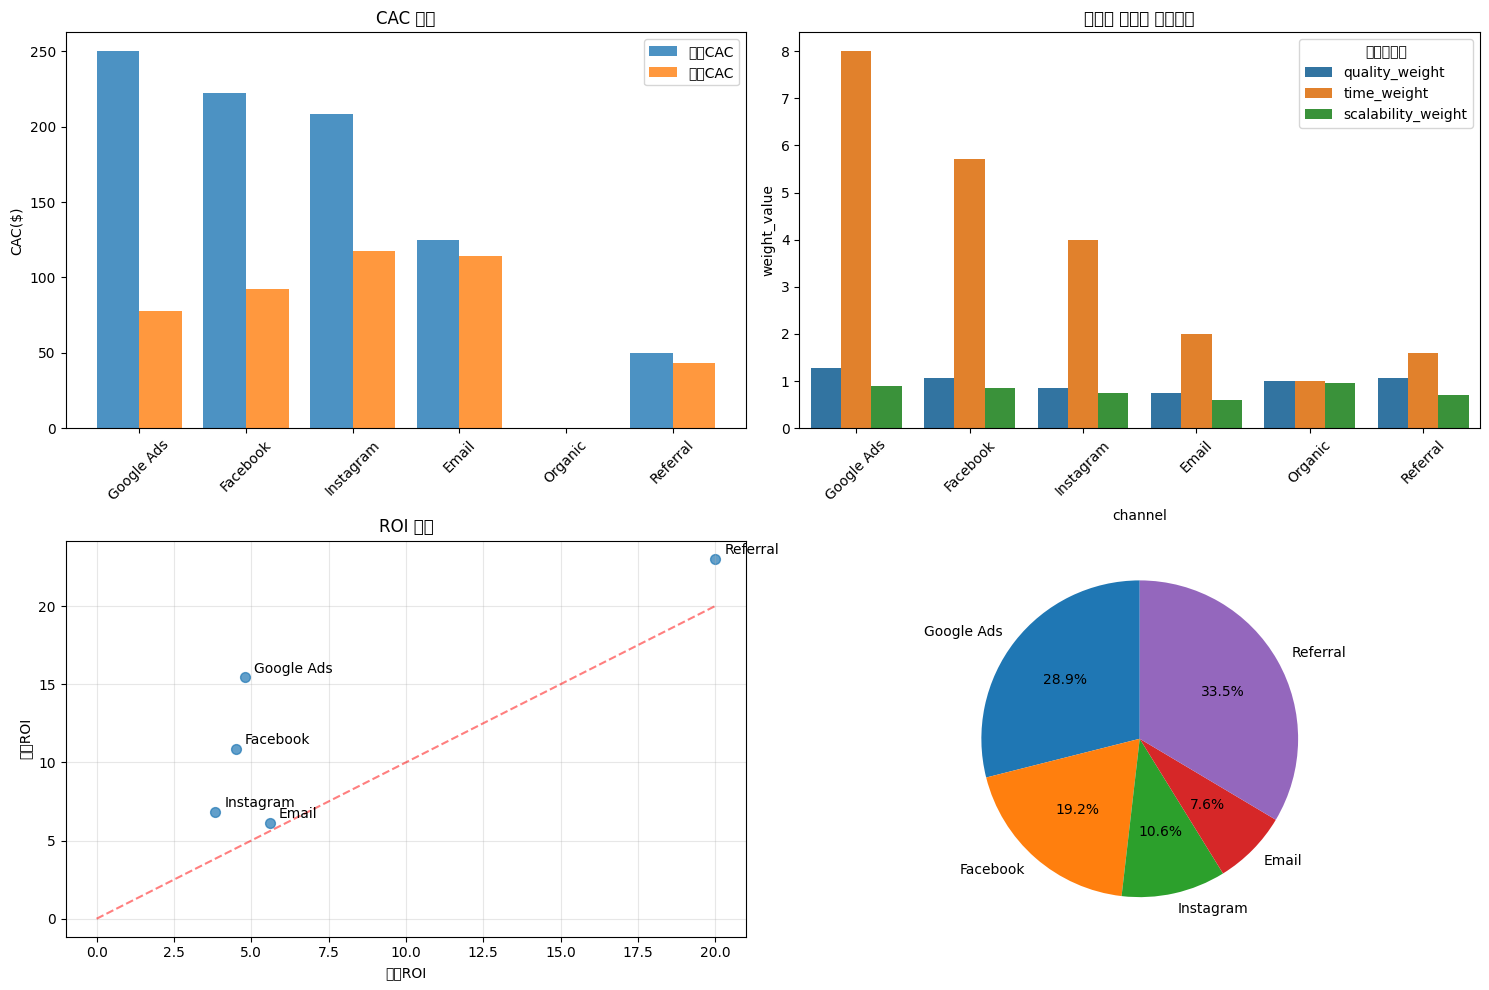

In [197]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
x_pos = np.arange(len(perf_df))
a1, a2, a3, a4 = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]

# 단순 CAC, 가중 CAC 비교
a1.bar(x_pos-0.2, perf_df['simple_cac'], 0.4, label='단순CAC', alpha=0.8)
a1.bar(x_pos+0.2, perf_df['weighted_cac'], 0.4, label='가중CAC', alpha=0.8)
a1.set_title('CAC 비교')
a1.set_xticks(x_pos)
a1.set_xticklabels(perf_df['channel'], rotation=45)
a1.set_ylabel('CAC($)')
a1.legend()

# 가중치 구성요소 분석
weight_comp = perf_df[['channel', 'quality_weight', 'time_weight', 'scalability_weight']]
# pivot <-> melt
weight_melted = weight_comp.melt(id_vars=['channel'], var_name='weight_type', value_name='weight_value')
import seaborn as sns
sns.barplot(data=weight_melted, x='channel', y='weight_value', hue='weight_type', ax=a2)
a2.tick_params(axis='x', rotation=45)
a2.set_title('채널별 가중치 구성요소')
a2.legend(title='가중치유형')


# ROI 분석 (LTV/CAC 비율)
perf_df['simple_roi'] = perf_df['avg_ltv'] / perf_df['simple_cac']
perf_df['weighted_roi'] = perf_df['avg_ltv'] / perf_df['weighted_cac']
# 산점도
a3.scatter(perf_df['simple_roi'], perf_df['weighted_roi'], s=50, alpha=0.7)
# 각 점마다 채널명 표시하기
for idx, channel in enumerate(perf_df['channel']):
    a3.annotate(channel, (perf_df['simple_roi'].iloc[idx]+0.3, perf_df['weighted_roi'].iloc[idx]+0.3))

# 대각선 그리기 -> 선 위의 점들은 과소평가된 채널들 / 선 아래 점들은 점검해볼 채널
a3.plot([0, 20], [0, 20], 'r--', alpha=0.5)

a3.set_title('ROI 비교')
a3.set_xlabel('단순ROI')
a3.set_ylabel('가중ROI')
a3.grid(True, alpha=0.3)

# 최적 마케팅 믹스 제안 (파이 그래프)
"""
ROI 와 Scalability 를 함께 고려할 예정
1. 효율성 지표(Efficiency Score) 라는 항목으로 ROI, 확장성을 동시에 계산 -> 성과도 좋고 확장 여지도 크다
2. 예산 배분 기준 -> 효율성 지표에 따라
"""
budget_opt = perf_df.copy()
# Organic 행 삭제
budget_opt.drop(4, axis=0, inplace=True)
# 숫자가 너무 커서 나눔
budget_opt['eff_score'] = budget_opt['weighted_roi'] * budget_opt['scalability_score'] / 100
budget_opt['recommend_pct'] = budget_opt['eff_score'] / budget_opt['eff_score'].sum() * 100

a4.pie(budget_opt['recommend_pct'], labels=budget_opt['channel'], autopct='%1.1f%%', startangle=90)

plt.tight_layout()
plt.show()